In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import importlib
import math

import torch
import torch.cuda
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim
import torch.nn.functional as F 
from IPython.display import clear_output

In [2]:
import logging
import io

logger = logging.getLogger('basic_logger')
logger.setLevel(logging.DEBUG)
log_capture_string = io.StringIO()
ch = logging.StreamHandler(log_capture_string)
ch.setLevel(logging.DEBUG)
logger.addHandler(ch)

In [4]:
import sampler
import dataset
importlib.reload(dataset)
importlib.reload(sampler)

import LegNet
import model

In [5]:
# Since the legnet predictor is trained to predict the expression of 150 nt long sequences, we add flanks from the plasmid.

PLASMID = "aactctcaaggatcttaccgctgttgagatccagttcgatgtaacccactcgtgcacccaactgatcttcagcatcttttactttcaccagcgtttctgggtgagcaaaaacaggaaggcaaaatgccgcaaaaaagggaataagggcgacacggaaatgttgaatactcatactcttcctttttcaatattattgaagcatttatcagggttattgtctcatgagcggatacatatttgaatgtatttagaaaaataaacaaataggggttccgcgcacatttccccgaaaagtgccacctgacgtcatctatattaccctgttatccctagcggatctgccggtagaggtgtggtcaataagagcgacctcatactatacctgagaaagcaacctgacctacaggaaagagttactcaagaataagaattttcgttttaaaacctaagagtcactttaaaatttgtatacacttattttttttataacttatttaataataaaaatcataaatcataagaaattcgcttatttagaagtGGCGCGCCGGTCCGttacttgtacagctcgtccatgccgccggtggagtggcggccctcggcgcgttcgtactgttccacgatggtgtagtcctcgttgtgggaggtgatgtccaacttgatgttgacgttgtaggcgccgggcagctgcacgggcttcttggccttgtaggtggtcttgacctcagcgtcgtagtggccgccgtccttcagcttcagcctctgcttgatctcgcccttcagggcgccgtcctcggggtacatccgctcggaggaggcctcccagcccatggtcttcttctgcattacggggccgtcggaggggaagttggtgccgcgcagcttcaccttgtagatgaactcgccgtcctgcagggaggagtcctgggtcacggtcaccacgccgccgtcctcgaagttcatcacgcgctcccacttgaagccctcggggaaggacagcttcaagtagtcggggatgtcggcggggtgcttcacgtaggccttggagccgtacatgaactgaggggacaggatgtcccaggcgaagggcagggggccacccttggtcaccttcagcttggcggtctgggtgccctcgtaggggcggccctcgccctcgccctcgatctcgaactcgtggccgttcacggagccctccatgtgcaccttgaagcgcatgaactccttgatgatggccatgttatcctcctcgcccttgctcacCATGGTACTAGTGTTTAGTTAATTATAGTTCGTTGACCGTATATTCTAAAAACAAGTACTCCTTAAAAAAAAACCTTGAAGGGAATAAACAAGTAGAATAGATAGAGAGAAAAATAGAAAATGCAAGAGAATTTATATATTAGAAAGAGAGAAAGAAAAATGGAAAAAAAAAAATAGGAAAAGCCAGAAATAGCACTAGAAGGAGCGACACCAGAAAAGAAGGTGATGGAACCAATTTAGCTATATATAGTTAACTACCGGCTCGATCATCTCTGCCTCCAGCATAGTCGAAGAAGAATTTTTTTTTTCTTGAGGCTTCTGTCAGCAACTCGTATTTTTTCTTTCTTTTTTGGTGAGCCTAAAAAGTTCCCACGTTCTCTTGTACGACGCCGTCACAAACAACCTTATGGGTAATTTGTCGCGGTCTGGGTGTATAAATGTGTGGGTGCAACATGAATGTACGGAGGTAGTTTGCTGATTGGCGGTCTATAGATACCTTGGTTATGGCGCCCTCACAGCCGGCAGGGGAAGCGCCTACGCTTGACATCTACTATATGTAAGTATACGGCCCCATATATAggccctttcgtctcgcgcgtttcggtgatgacggtgaaaacctctgacacatgcagctcccggagacggtcacagcttgtctgtaagcggatgccgggagcagacaagcccgtcagggcgcgtcagcgggtgttggcgggtgtcggggctggcttaactatgcggcatcagagcagattgtactgagagtgcaccatatggacatattgtcgttagaacgcggctacaattaatacataaccttatgtatcatacacatacgatttaggtgacactatagaacgcggccgccagctgaagctttaactatgcggcatcagagcagattgtactgagagtgcaccataccaccttttcaattcatcattttttttttattcttttttttgatttcggtttccttgaaatttttttgattcggtaatctccgaacagaaggaagaacgaaggaaggagcacagacttagattggtatatatacgcatatgtagtgttgaagaaacatgaaattgcccagtattcttaacccaactgcacagaacaaaaacctgcaggaaacgaagataaatcatgtcgaaagctacatataaggaacgtgctgctactcatcctagtcctgttgctgccaagctatttaatatcatgcacgaaaagcaaacaaacttgtgtgcttcattggatgttcgtaccaccaaggaattactggagttagttgaagcattaggtcccaaaatttgtttactaaaaacacatgtggatatcttgactgatttttccatggagggcacagttaagccgctaaaggcattatccgccaagtacaattttttactcttcgaagacagaaaatttgctgacattggtaatacagtcaaattgcagtactctgcgggtgtatacagaatagcagaatgggcagacattacgaatgcacacggtgtggtgggcccaggtattgttagcggtttgaagcaggcggcagaagaagtaacaaaggaacctagaggccttttgatgttagcagaattgtcatgcaagggctccctatctactggagaatatactaagggtactgttgacattgcgaagagcgacaaagattttgttatcggctttattgctcaaagagacatgggtggaagagatgaaggttacgattggttgattatgacacccggtgtgggtttagatgacaagggagacgcattgggtcaacagtatagaaccgtggatgatgtggtctctacaggatctgacattattattgttggaagaggactatttgcaaagggaagggatgctaaggtagagggtgaacgttacagaaaagcaggctgggaagcatatttgagaagatgcggccagcaaaactaaaaaactgtattataagtaaatgcatgtatactaaactcacaaattagagcttcaatttaattatatcagttattaccctatgcggtgtgaaataccgcacagatgcgtaaggagaaaataccgcatcaggaaattgtaagcgttaatattttgttaaaattcgcgttaaatttttgttaaatcagctcattttttaaccaataggccgaaatcggcaaaatcccttataaatcaaaagaatagaccgagatagggttgagtgttgttccagtttggaacaagagtccactattaaagaacgtggactccaacgtcaaagggcgaaaaaccgtctatcagggcgatggcccactacgtgaaccatcaccctaatcaagtGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATCNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGGTTACGGCTGTTTCTTAATTAAAAAAAGATAGAAAACATTAGGAGTGTAACACAAGACTTTCGGATCCTGAGCAGGCAAGATAAACGAAGGCAAAGatgtctaaaggtgaagaattattcactggtgttgtcccaattttggttgaattagatggtgatgttaatggtcacaaattttctgtctccggtgaaggtgaaggtgatgctacttacggtaaattgaccttaaaattgatttgtactactggtaaattgccagttccatggccaaccttagtcactactttaggttatggtttgcaatgttttgctagatacccagatcatatgaaacaacatgactttttcaagtctgccatgccagaaggttatgttcaagaaagaactatttttttcaaagatgacggtaactacaagaccagagctgaagtcaagtttgaaggtgataccttagttaatagaatcgaattaaaaggtattgattttaaagaagatggtaacattttaggtcacaaattggaatacaactataactctcacaatgtttacatcactgctgacaaacaaaagaatggtatcaaagctaacttcaaaattagacacaacattgaagatggtggtgttcaattagctgaccattatcaacaaaatactccaattggtgatggtccagtcttgttaccagacaaccattacttatcctatcaatctgccttatccaaagatccaaacgaaaagagagaccacatggtcttgttagaatttgttactgctgctggtattacccatggtatggatgaattgtacaaataaggcgcgccacttctaaataagcgaatttcttatgatttatgatttttattattaaataagttataaaaaaaataagtgtatacaaattttaaagtgactcttaggttttaaaacgaaaattcttattcttgagtaactctttcctgtaggtcaggttgctttctcaggtatagtatgaggtcgctcttattgaccacacctctaccggcagatccgctagggataacagggtaatataGATCTGTTTAGCTTGCCTCGTCCCCGCCGGGTCACCCGGCCAGCGACATGGAGGCCCAGAATACCCTCCTTGACAGTCTTGACGTGCGCAGCTCAGGGGCATGATGTGACTGTCGCCCGTACATTTAGCCCATACATCCCCATGTATAATCATTTGCATCCATACATTTTGATGGCCGCACGGCGCGAAGCAAAAATTACGGCTCCTCGCTGCAGACCTGCGAGCAGGGAAACGCTCCCCTCACAGACGCGTTGAATTGTCCCCACGCCGCGCCCCTGTAGAGAAATATAAAAGGTTAGGATTTGCCACTGAGGTTCTTCTTTCATATACTTCCTTTTAAAATCTTGCTAGGATACAGTTCTCACATCACATCCGAACATAAACAACCATGGGTACCACTCTTGACGACACGGCTTACCGGTACCGCACCAGTGTCCCGGGGGACGCCGAGGCCATCGAGGCACTGGATGGGTCCTTCACCACCGACACCGTCTTCCGCGTCACCGCCACCGGGGACGGCTTCACCCTGCGGGAGGTGCCGGTGGACCCGCCCCTGACCAAGGTGTTCCCCGACGACGAATCGGACGACGAATCGGACGACGGGGAGGACGGCGACCCGGACTCCCGGACGTTCGTCGCGTACGGGGACGACGGCGACCTGGCGGGCTTCGTGGTCGTCTCGTACTCCGGCTGGAACCGCCGGCTGACCGTCGAGGACATCGAGGTCGCCCCGGAGCACCGGGGGCACGGGGTCGGGCGCGCGTTGATGGGGCTCGCGACGGAGTTCGCCCGCGAGCGGGGCGCCGGGCACCTCTGGCTGGAGGTCACCAACGTCAACGCACCGGCGATCCACGCGTACCGGCGGATGGGGTTCACCCTCTGCGGCCTGGACACCGCCCTGTACGACGGCACCGCCTCGGACGGCGAGCAGGCGCTCTACATGAGCATGCCCTGCCCCTAATCAGTACTGACAATAAAAAGATTCTTGTTTTCAAGAACTTGTCATTTGTATAGTTTTTTTATATTGTAGTTGTTCTATTTTAATCAAATGTTAGCGTGATTTATATTTTTTTTCGCCTCGACATCATCTGCCCAGATGCGAAGTTAAGTGCGCAGAAAGTAATATCATGCGTCAATCGTATGTGAATGCTGGTCGCTATACTGCTGTCGATTCGATACTAACGCCGCCATCCAGTGTCGAAAACGAGCTCGaattcctgggtccttttcatcacgtgctataaaaataattataatttaaattttttaatataaatatataaattaaaaatagaaagtaaaaaaagaaattaaagaaaaaatagtttttgttttccgaagatgtaaaagactctagggggatcgccaacaaatactaccttttatcttgctcttcctgctctcaggtattaatgccgaattgtttcatcttgtctgtgtagaagaccacacacgaaaatcctgtgattttacattttacttatcgttaatcgaatgtatatctatttaatctgcttttcttgtctaataaatatatatgtaaagtacgctttttgttgaaattttttaaacctttgtttatttttttttcttcattccgtaactcttctaccttctttatttactttctaaaatccaaatacaaaacataaaaataaataaacacagagtaaattcccaaattattccatcattaaaagatacgaggcgcgtgtaagttacaggcaagcgatccgtccGATATCatcagatccactagtggcctatgcggccgcggatctgccggtctccctatagtgagtcgtattaatttcgataagccaggttaacctgcattaatgaatcggccaacgcgcggggagaggcggtttgcgtattgggcgctcttccgcttcctcgctcactgactcgctgcgctcggtcgttcggctgcggcgagcggtatcagctcactcaaaggcggtaatacggttatccacagaatcaggggataacgcaggaaagaacatgtgagcaaaaggccagcaaaaggccaggaaccgtaaaaaggccgcgttgctggcgtttttccataggctccgcccccctgacgagcatcacaaaaatcgacgctcaagtcagaggtggcgaaacccgacaggactataaagataccaggcgtttccccctggaagctccctcgtgcgctctcctgttccgaccctgccgcttaccggatacctgtccgcctttctcccttcgggaagcgtggcgctttctcaTAgctcacgctgtaggtatctcagttcggtgtaggtcgttcgctccaagctgggctgtgtgcacgaaccccccgttcagcccgaccgctgcgccttatccggtaactatcgtcttgagtccaacccggtaagacacgacttatcgccactggcagcagccactggtaacaggattagcagagcgaggtatgtaggcggtgctacagagttcttgaagtggtggcctaactacggctacactagaagAacagtatttggtatctgcgctctgctgaagccagttaccttcggaaaaagagttggtagctcttgatccggcaaacaaaccaccgctggtagcggtggtttttttgtttgcaagcagcagattacgcgcagaaaaaaaggatctcaagaagatcctttgatcttttctacggggtctgacgctcagtggaacgaaaactcacgttaagggattttggtcatgagattatcaaaaaggatcttcacctagatccttttaaattaaaaatgaagttttaaatcaatctaaagtatatatgagtaaacttggtctgacagttaccaatgcttaatcagtgaggcacctatctcagcgatctgtctatttcgttcatccatagttgcctgactccccgtcgtgtagataactacgatacgggagggcttaccatctggccccagtgctgcaatgataccgcgagacccacgTtcaccggctccagatttatcagcaataaaccagccagccggaagggccgagcgcagaagtggtcctgcaactttatccgcctccatccagtctattaattgttgccgggaagctagagtaagtagttcgccagttaatagtttgcgcaacgttgttgccattgctacaggcatcgtggtgtcacgctcgtcgtttggtatggcttcattcagctccggttcccaacgatcaaggcgagttacatgatcccccatgttgtgcaaaaaagcggttagctccttcggtcctccgatcgttgtcagaagtaagttggccgcagtgttatcactcatggttatggcagcactgcataattctcttactgtcatgccatccgtaagatgcttttctgtgactggtgagtactcaaccaagtcattctgagaatagtgtatgcggcgaccgagttgctcttgcccggcgtcaatacgggataataccgcgccacatagcagaactttaaaagtgctcatcattggaaaacgttcttcggggcgaa"
PLASMID = PLASMID.upper()
INSERT_START = PLASMID.find('N'*80)
LEFT_ADAPTER = "TGCATTTTTTTCACATC" 
RIGHT_ADAPTER = "GGTTACGGCTGTT"
def preprocess_data(data, length):
    data = data.copy()
    add_part = PLASMID[INSERT_START-length:INSERT_START]
    data.seq = data.seq.apply(lambda x:  add_part + x[len(LEFT_ADAPTER):])
    data.seq = data.seq.str.slice(-length, None)
    return data

CODES = {
    "A": 0,
    "T": 3,
    "G": 1,
    "C": 2
}
RIGHT = 'GGTTACGGCTGTT'
LEFT = 'AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATTTTTTTCACATC'

def n2id(n):
    return CODES[n.upper()]

class Seq2Tensor(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, seq):
        if isinstance(seq, torch.FloatTensor):
            return seq
        seq = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq))
        code = F.one_hot(code, num_classes=4)
        code = code[:, :4].float()
        return code.transpose(0, 1)
s2t = Seq2Tensor()
right_s2t = torch.concat((s2t(RIGHT), torch.zeros(2, s2t(RIGHT).shape[1])))
left_s2t = torch.concat((s2t(LEFT), torch.zeros(2, s2t(LEFT).shape[1])))

In [6]:
N = 'full' # load full dataset
mut = (0,301) # limit of mutations from 0 to 300
epochs = 200 # specify the number of training epochs
batch_size = 1024 # number of sequences in a batch
batch_per_epoch = 1000 # number of batches in one epoch 
num_workers = 8
lr = 0.001
device = torch.device("cuda:0") 

In [8]:
PATH_FROM = 'path' # path to training data

if N == 'full':
    df = sampler.load_full(PATH_FROM, start=0, end=18, length=110, N_contain=False)  # load only sequens with 80 b.p length, without N

my_df = dataset.PromotersData(df, cleave_left=17,
                 cleave_right=13, limits=mut)  # create dataset class and cleve adapters
my_df.data

,seq,expression
0,GAGTATTTTAACTACCACAGACGCGCATAACGTGGTCGTGACTGGT...,11.000000
1,ATAGAAATAGTGGTATTTCGCTAGGGCGATAGGGTCCGTCCCTCTG...,9.845684
2,GGCGGCACGAGATTTGAGTCAGCGTACGCCGTCGTGTACAAGTTCG...,11.000000
3,TACTTGTTGCATGTGCTGGGTATGTGGGTCGCGTTTTGTGTGAGTG...,12.000000
4,TTGTATAACGGCTATGGCAGGTGCCTATTTCGCCATACTAAGTAAG...,12.255336
...,...,...
5510997,AAAGCCAATGCCTCGATTAGGGCATCGTATCAGGACGCGGGAATGT...,10.238767
5510998,TTTATTACGTGCCCCGGAGATGATGGGTGTATACAGGATGGTGTGC...,11.324707
5510999,AAAGTATGACAAAATTATTTTTTTATACCAAGTTTCGGAAATTCTT...,13.000000
5511000,CATTGGACCGTTTTAGAGACCGAGATGGCAAAGATTTGTTGGAACC...,11.000000


In [9]:
def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        n = m.kernel_size[0] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2 / n))
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.001)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
            
class DataloaderWrapper:
    def __init__(self, dataloader, batch_per_epoch):
        self.batch_per_epoch = batch_per_epoch
        self.dataloader = dataloader
        self.iterator = iter(dataloader)

    def __len__(self):
        return self.batch_per_epoch
    
    def __next__(self):
        try:
            return next(self.iterator)
        except StopIteration:
            self.iterator = iter(self.dataloader)

    def __iter__(self):
        for _ in range(self.batch_per_epoch):
            try:
                yield next(self.iterator)
            except StopIteration:
                self.iterator = iter(self.dataloader)

In [10]:

legnet = LegNet.LegNet(80,
                      ks=7,
                block_sizes=[256, 128, 128, 64, 64, 64, 64],
                final_ch=4).to(device)

legnet.apply(initialize_weights)
clear_output()


In [ ]:
PRETRANED_MODEL_PATH = '../models/predictor/model_80.pth' #pretraned legNet-predictor

pretraned_model = model.SeqNN(150,
                ks=7,
                use_single_channel=True,
                block_sizes=[256, 128, 128, 64, 64, 64, 64],
                final_ch=18).to(device)

pretraned_model.load_state_dict(torch.load(PRETRANED_MODEL_PATH, map_location=device))

In [ ]:
all_size = my_df.data.shape[0]

train_set, val_set = torch.utils.data.random_split(my_df, [0.8, 0.2])

dl_train = DataLoader(train_set,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      worker_init_fn = lambda id: np.random.seed(id)
                     )
dl_train = DataloaderWrapper(dl_train, batch_per_epoch=batch_per_epoch)
dl_test = DataLoader(val_set,
                     batch_size=batch_size,
                     num_workers=num_workers,
                     shuffle=False,
                     worker_init_fn = lambda id: np.random.seed(id)
                    )
dl_test = DataloaderWrapper(dl_test, batch_per_epoch=batch_per_epoch)

optimizer = torch.optim.AdamW(legnet.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
score_criterion=nn.MSELoss()


In [12]:
class Trainer:
    def __init__(self,
            model: torch.nn.Module, 
            pretraned_model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader ,
            test_dataloader: torch.utils.data.DataLoader ,
            criterion: torch.nn.CrossEntropyLoss,
            loss_criterion: torch.nn.CrossEntropyLoss,
            optimizer: torch.optim.Optimizer,
            epochs: int,
            batch_size: int = 1024,
            batch_per_epoch: int = 1000,
            device = torch.device("cuda:0")
            ):
        self.optimizer = optimizer
        self.criterion = criterion
        self.score_criterion = loss_criterion
        self.model = model
        self.pretraned_model = pretraned_model
        self.train_dl = train_dataloader
        self.test_dl = test_dataloader
        self.epochs = epochs
        self.batch_per_epoch = batch_per_epoch
        self.device = device
        self.batch_size = batch_size
        self.score_cor_mean = []
        self.score = []
            
    def train(self, epoch):
        print(f'start training, epoch = {epoch}')
        self.model.train()
        ltr = []
        for _, data in tqdm(enumerate(self.train_dl), mininterval=60):
            target_seq, mutated_seq, _ = data
            target_seq, mutated_seq = target_seq.float().to(self.device), mutated_seq.float().to(self.device) 
            pred = self.model(mutated_seq)
            loss = self.criterion(pred, target_seq)
            ltr.append(loss.item())
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad() 

        mean_loss = np.mean(ltr)
        return mean_loss
    
    def validate(self, epoch):
        print(f'start validating, epoch = {epoch}')
        with torch.no_grad():
            self.model.eval()
            self.pretraned_model.eval()
            lte = []
            score_losses = []
            score_cores = []
            
            
            for _, data in tqdm(enumerate(self.test_dl), mininterval=60):
                target_seq_val, mutated_seq_val, _ = data
                mutated_seq_val, target_seq_val = mutated_seq_val.float().to(self.device), target_seq_val.float().to(self.device)

                target_score = mutated_seq_val[:,4,1].clone()
                mutated_seq = mutated_seq_val[:,:4,:].clone()
                mut_seqs = torch.concat((mutated_seq, torch.zeros(mutated_seq.shape[0],2,mutated_seq.shape[2], device=self.device)), dim=1)
                left_batch = torch.broadcast_to(left_s2t, (mut_seqs.shape[0], left_s2t.shape[0], left_s2t.shape[1])).to(self.device)
                right_batch = torch.broadcast_to(right_s2t, (mut_seqs.shape[0], right_s2t.shape[0], right_s2t.shape[1])).to(self.device)


                pred = self.model(mutated_seq_val)
                pred_seq = torch.softmax(pred, dim=1)
                loss = self.criterion(pred_seq, target_seq_val)
                lte.append(loss.item())
                
                seqs = torch.concat((pred_seq, torch.zeros(pred_seq.shape[0], 2, pred_seq.shape[2], device=device)), dim=1)
                
                long_pred = torch.concat((left_batch, seqs, right_batch), dim=2)
                pred_score = self.pretraned_model(long_pred)[1]
                
                score_loss = self.score_criterion(pred_score, target_score)
                score_losses.append(score_loss.item())
                score_cor = stats.pearsonr(pred_score.cpu().numpy(), target_score.cpu().numpy())[0]
                score_cores.append(score_cor)

                
            self.score.append(np.mean(score_losses))
            self.score_cor_mean.append(np.mean(score_cores))
            mean_loss_val = np.mean(lte)
            return mean_loss_val
       
        
    def training(self):
        
        self.save_dir = f"../saved_model/model_epochs_{self.epochs}"
        os.makedirs(self.save_dir, exist_ok=True)
        train_losses = []
        test_losses = []
        for epoch in tqdm(range(self.epochs)):
            tr_loss = self.train(epoch)
            train_losses.append(tr_loss)
  
            test_loss = self.validate(epoch)
            test_losses.append(test_loss)

            self.plotter(train_losses,test_losses, epoch)
            self.save_model(epoch,train_losses)
        return train_losses, test_losses, self.score
    

    def plotter(self, loss_train, loss_val, epoch):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1,  figsize=(7, 7))
        
        ax1.plot(loss_train, color='red')
        ax3.plot(loss_train, color='red')
        ax2.plot(loss_val, color='blue')
        ax3.plot(loss_val, color='blue')
        ax4.plot(self.score, color = 'black')
        ax5.plot(self.score_cor_mean, color = 'black')
        ax1.grid(axis='x')
        ax2.grid(axis='x')
        ax3.grid(axis='x')
        ax2.set_xlabel('Epoch')
        ax1.set_ylabel('Train Loss')
        ax3.set_ylabel('Train and val Loss')
        ax2.set_ylabel('Val Loss')
        ax4.set_ylabel('Score MSE')
        ax5.set_ylabel('Pearson cor')
        
        suptitle_string = f'epoch={epoch}'
        fig.suptitle(suptitle_string, y=1.05, fontsize=10)

        pic_test_name = os.path.join(self.save_dir, f"lossestrainandtest_epoch={epoch}.png")
        plt.tight_layout()
        fig.savefig(pic_test_name)
        fig.show()
        np.save(f'../saved_model/model_epochs_{self.epochs}/train_loss.npy', np.array(loss_train))
        np.save(f'../saved_model/model_epochs_{self.epochs}/test_loss.npy', np.array(loss_val))
        np.save(f'../saved_model/model_epochs_{self.epochs}/score_loss.npy', np.array(self.score))
        np.save(f'../saved_model/model_epochs_{self.epochs}/score_loss.npy', np.array(self.score_cor_mean))
            
    def save_model(self, epoch, losseshist):
        PATH = os.path.join(self.save_dir, f"model_{epoch}.pth")
            
        torch.save({
            'epoch' : epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': losseshist
            }, PATH)

        print(f'---------------  SAVED MODEL {PATH}-------------------')

  0%|          | 0/1000 [00:00<?, ?it/s]

start training, epoch = 0



1it [00:02,  2.66s/it]


start validating, epoch = 0



1it [00:00, 11.26it/s]
  0%|          | 1/1000 [00:03<56:50,  3.41s/it]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_0.pth-------------------
start training, epoch = 1



1it [00:00, 20.24it/s]


start validating, epoch = 1



1it [00:00, 47.75it/s]
  0%|          | 2/1000 [00:03<26:28,  1.59s/it]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_1.pth-------------------
start training, epoch = 2



1it [00:00, 26.15it/s]


start validating, epoch = 2



1it [00:00, 53.22it/s]
  0%|          | 3/1000 [00:04<16:47,  1.01s/it]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_2.pth-------------------
start training, epoch = 3



1it [00:00, 18.29it/s]


start validating, epoch = 3



1it [00:00, 45.84it/s]
  0%|          | 4/1000 [00:04<12:17,  1.35it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_3.pth-------------------
start training, epoch = 4



1it [00:00, 22.97it/s]


start validating, epoch = 4



1it [00:00, 48.26it/s]
  0%|          | 5/1000 [00:04<10:45,  1.54it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_4.pth-------------------
start training, epoch = 5



1it [00:00, 19.37it/s]


start validating, epoch = 5



1it [00:00, 57.11it/s]
  1%|          | 6/1000 [00:05<08:49,  1.88it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_5.pth-------------------
start training, epoch = 6



1it [00:00, 22.78it/s]


start validating, epoch = 6



1it [00:00, 50.08it/s]
  1%|          | 7/1000 [00:05<07:37,  2.17it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_6.pth-------------------
start training, epoch = 7



1it [00:00, 20.86it/s]


start validating, epoch = 7



1it [00:00, 58.53it/s]
  1%|          | 8/1000 [00:05<06:52,  2.41it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_7.pth-------------------
start training, epoch = 8



1it [00:00, 22.21it/s]


start validating, epoch = 8



1it [00:00, 51.77it/s]
  1%|          | 9/1000 [00:06<06:23,  2.58it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_8.pth-------------------
start training, epoch = 9



1it [00:00, 15.81it/s]


start validating, epoch = 9



1it [00:00, 50.99it/s]
  1%|          | 10/1000 [00:06<06:03,  2.72it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_9.pth-------------------
start training, epoch = 10



1it [00:00, 22.73it/s]


start validating, epoch = 10



1it [00:00, 54.75it/s]
  1%|          | 11/1000 [00:06<06:45,  2.44it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_10.pth-------------------
start training, epoch = 11



1it [00:00, 21.40it/s]


start validating, epoch = 11



1it [00:00, 55.78it/s]
  1%|          | 12/1000 [00:07<06:14,  2.64it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_11.pth-------------------
start training, epoch = 12



1it [00:00, 22.40it/s]


start validating, epoch = 12



1it [00:00, 38.88it/s]
  1%|▏         | 13/1000 [00:07<05:56,  2.77it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_12.pth-------------------
start training, epoch = 13



1it [00:00, 25.22it/s]


start validating, epoch = 13



1it [00:00, 55.81it/s]
  1%|▏         | 14/1000 [00:07<05:39,  2.90it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_13.pth-------------------
start training, epoch = 14



1it [00:00, 27.04it/s]


start validating, epoch = 14



1it [00:00, 57.86it/s]
  2%|▏         | 15/1000 [00:08<05:28,  2.99it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_14.pth-------------------
start training, epoch = 15



1it [00:00, 23.00it/s]


start validating, epoch = 15



1it [00:00, 34.67it/s]
  2%|▏         | 16/1000 [00:08<05:30,  2.98it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_15.pth-------------------
start training, epoch = 16



1it [00:00, 16.47it/s]


start validating, epoch = 16



1it [00:00, 51.13it/s]
  2%|▏         | 17/1000 [00:09<06:41,  2.45it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_16.pth-------------------
start training, epoch = 17



1it [00:00, 22.60it/s]


start validating, epoch = 17



1it [00:00, 50.10it/s]
  2%|▏         | 18/1000 [00:09<06:15,  2.61it/s]

---------------  SAVED MODEL ../saved_model/model_epochs_1000/model_17.pth-------------------
start training, epoch = 18



1it [00:00, 22.33it/s]


start validating, epoch = 18



1it [00:00, 49.12it/s]
  2%|▏         | 18/1000 [00:09<08:47,  1.86it/s]


KeyboardInterrupt: 

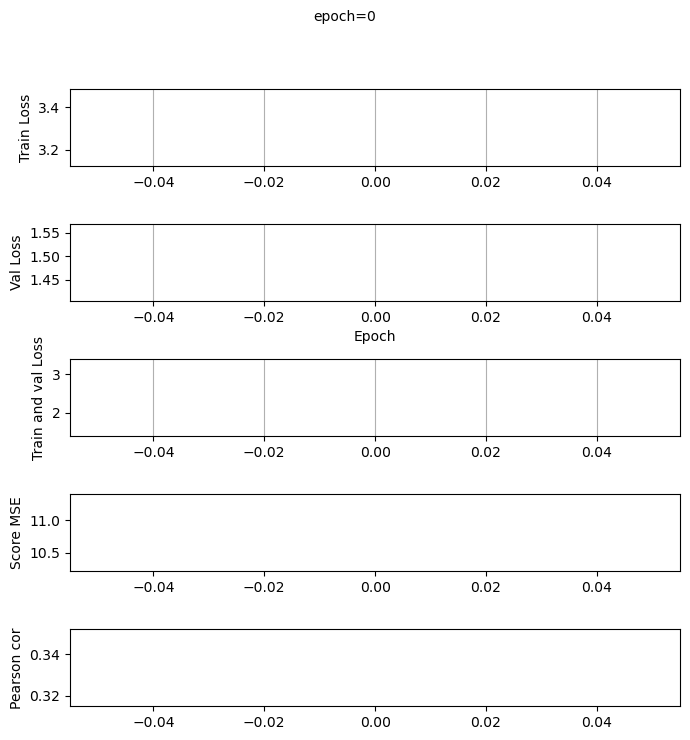

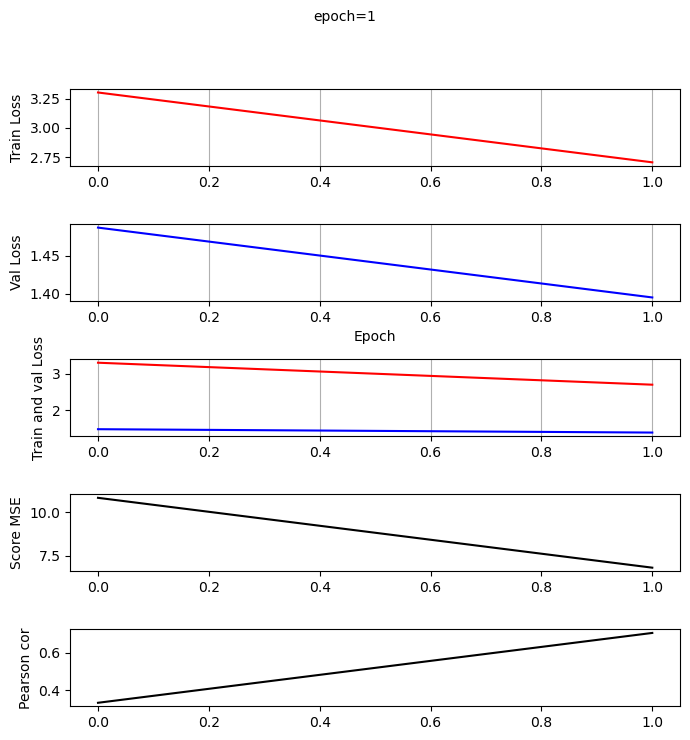

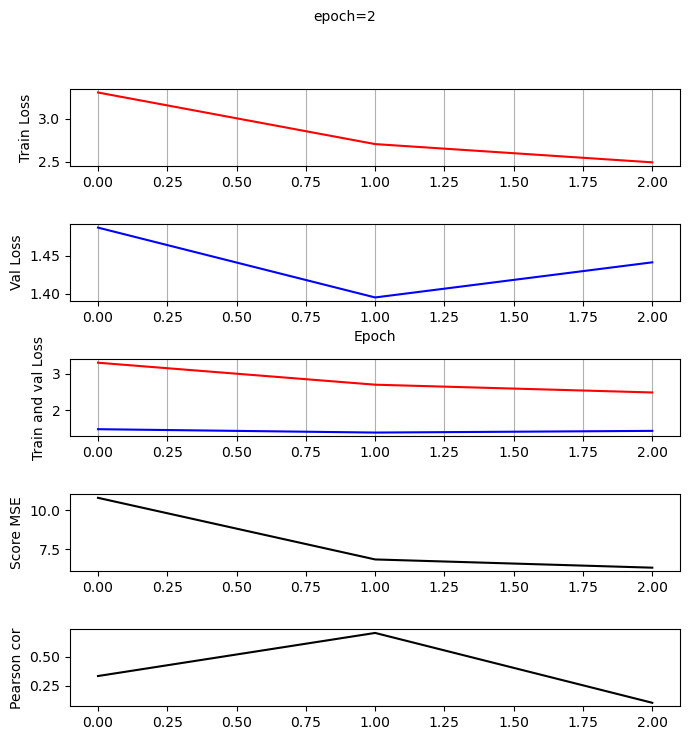

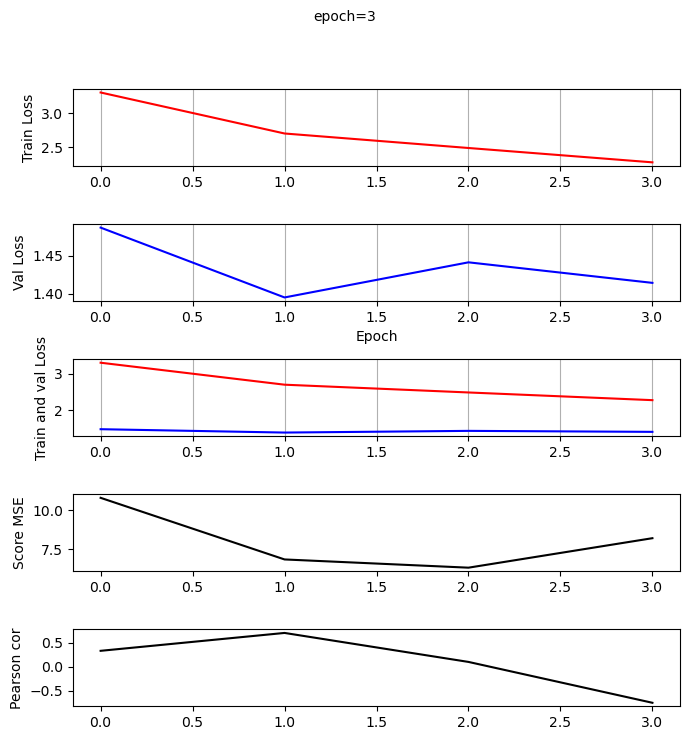

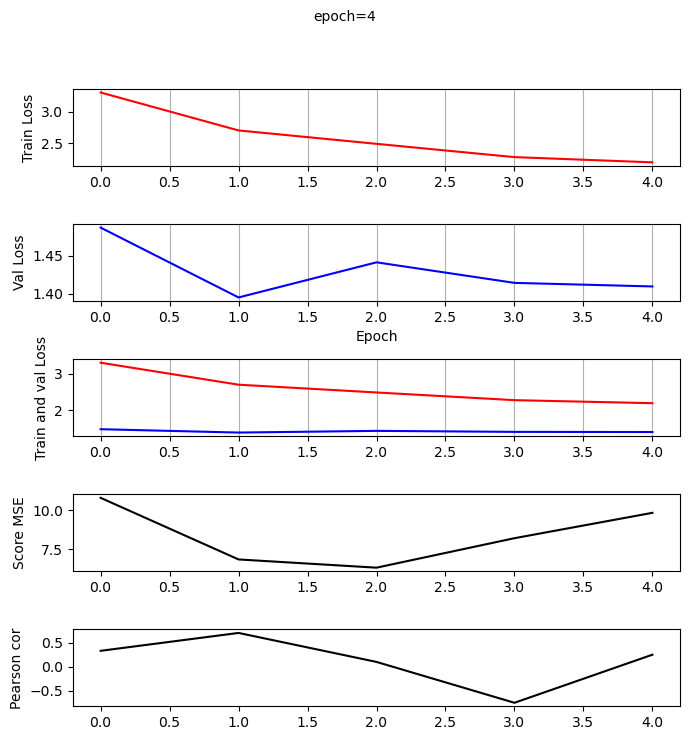

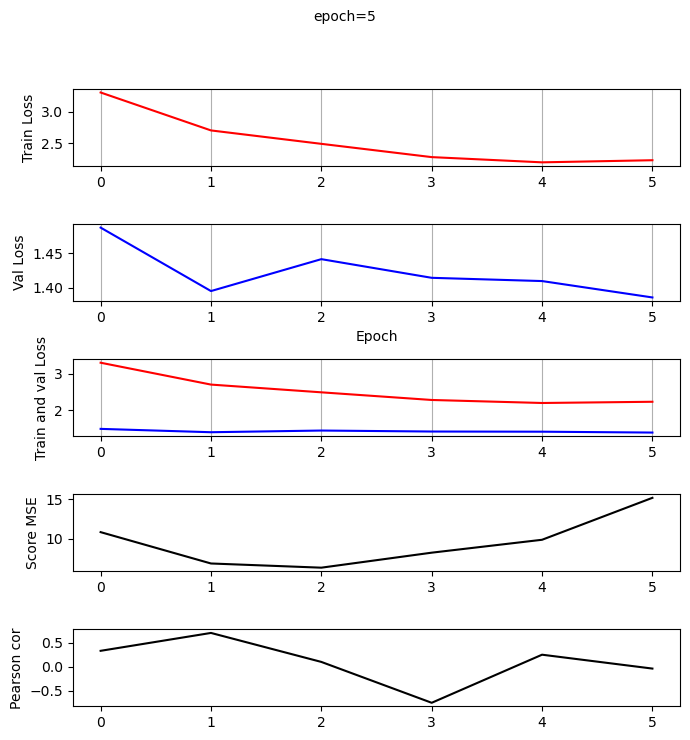

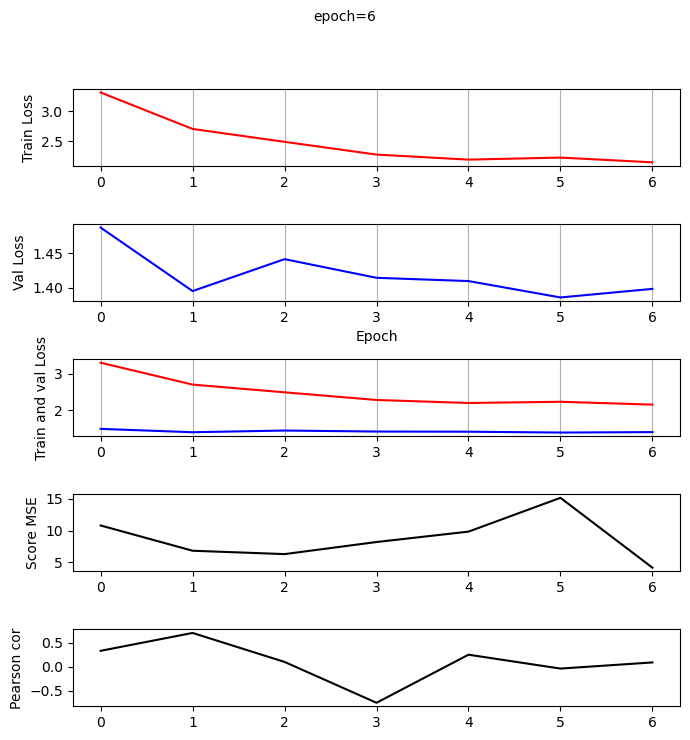

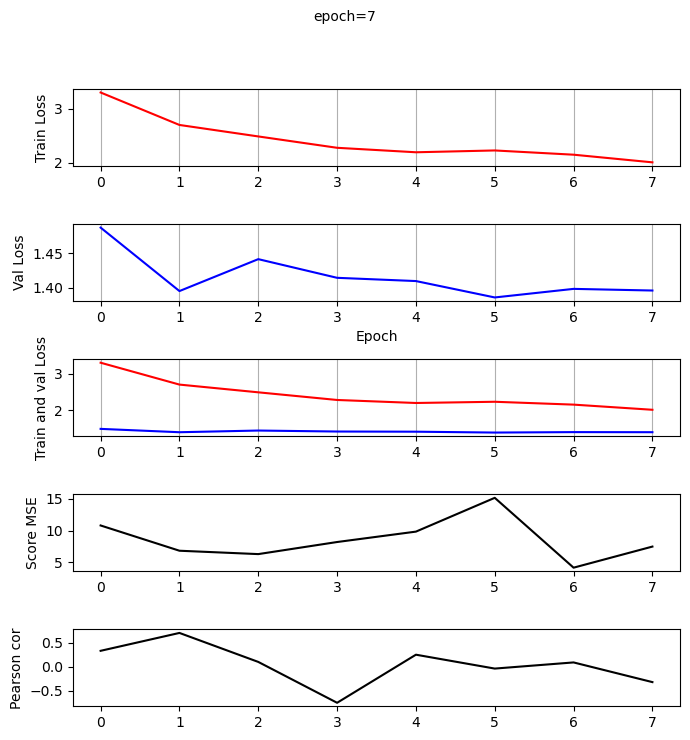

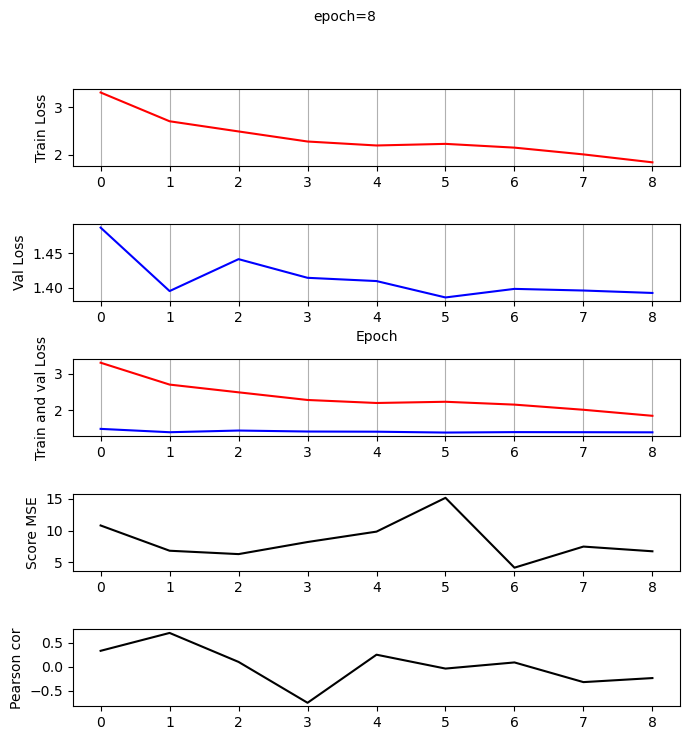

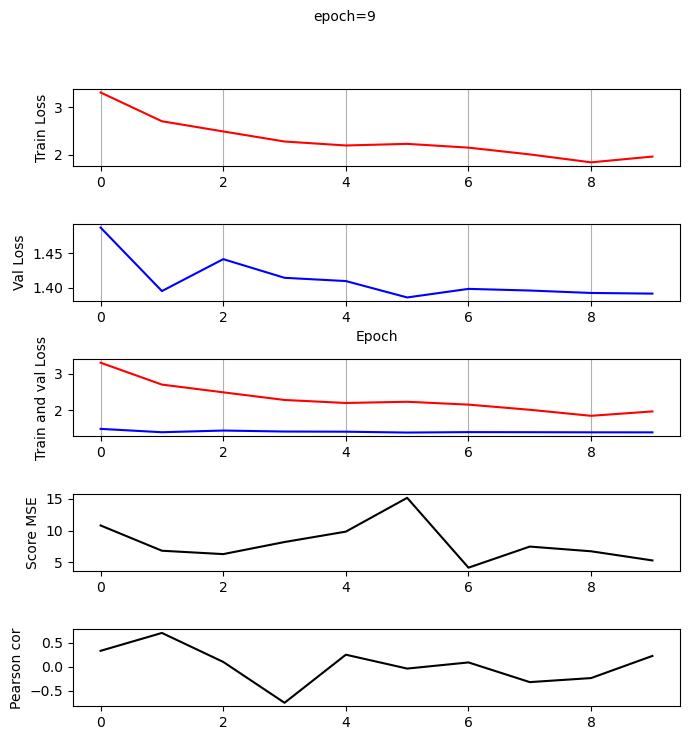

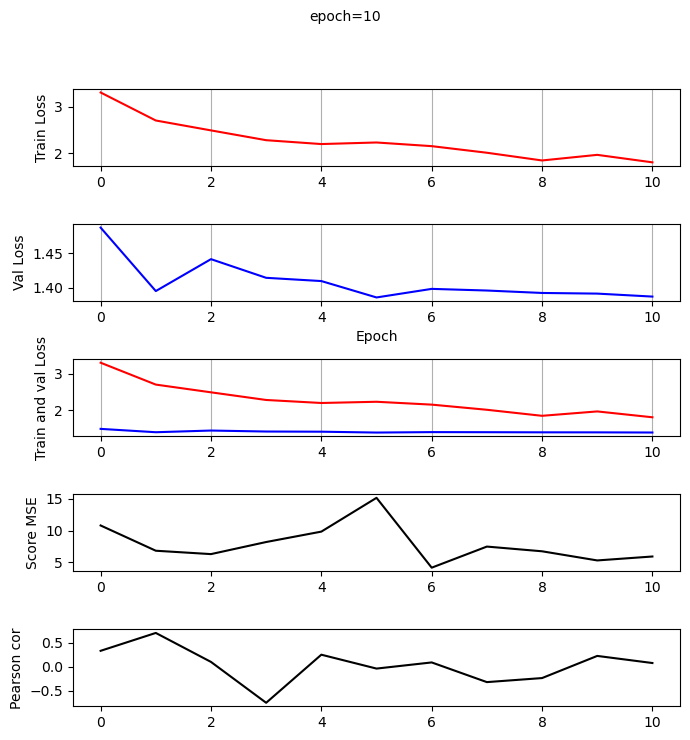

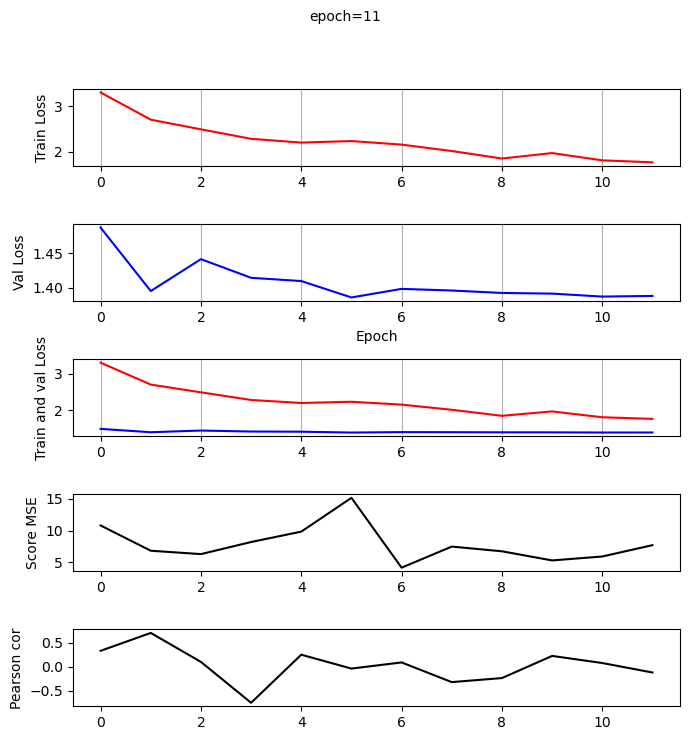

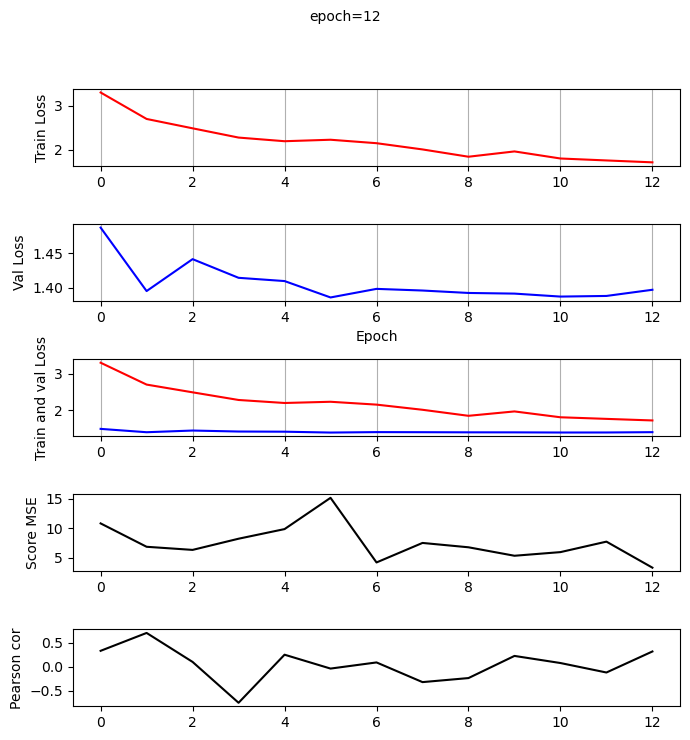

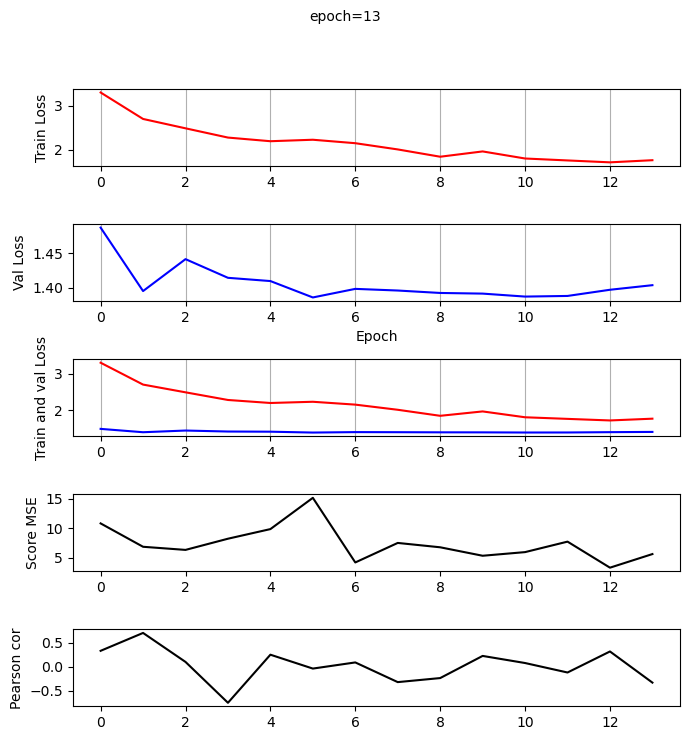

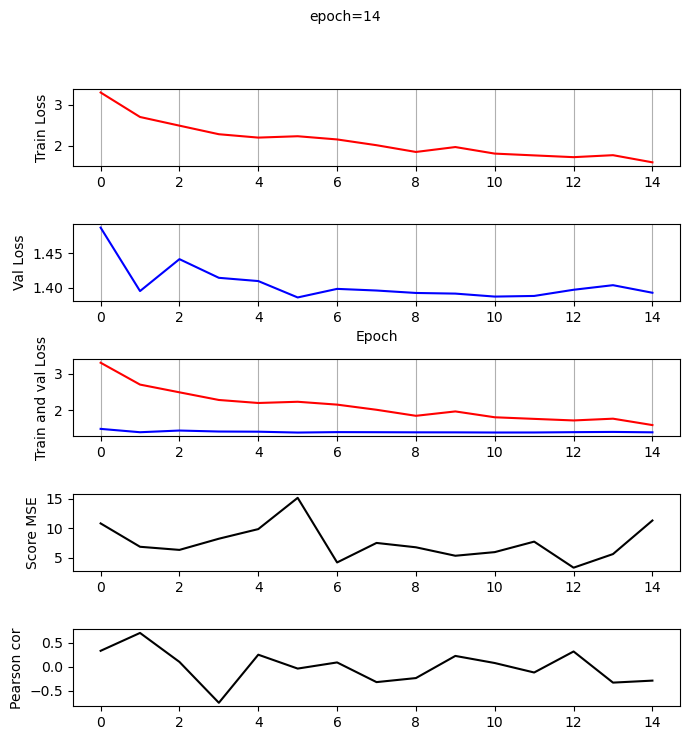

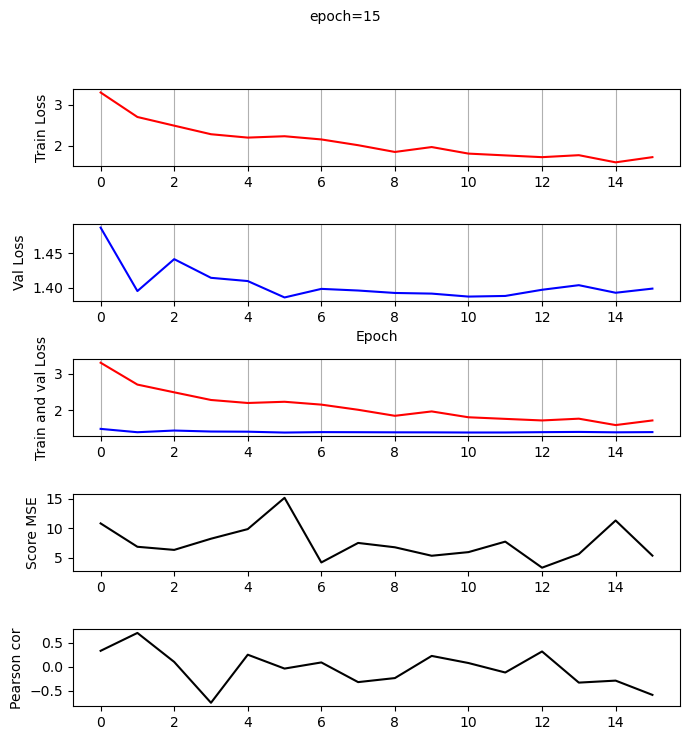

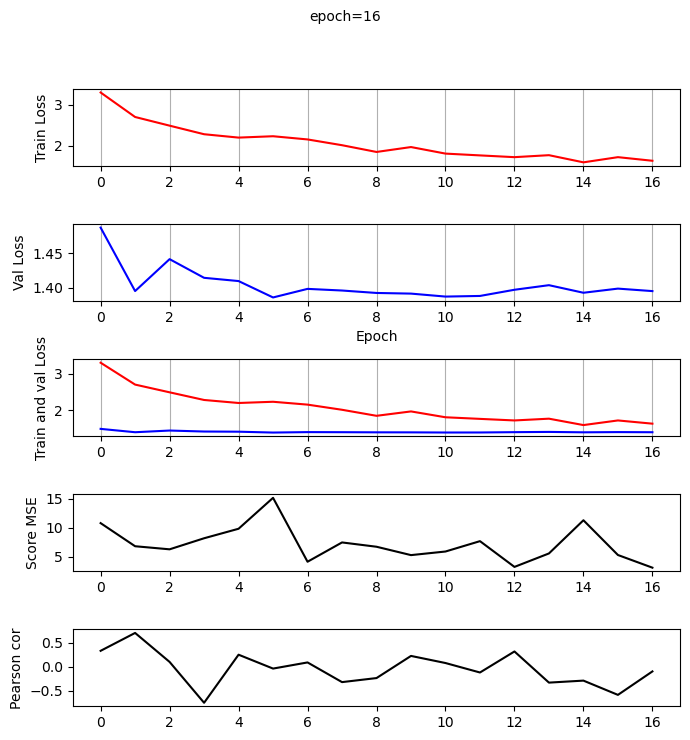

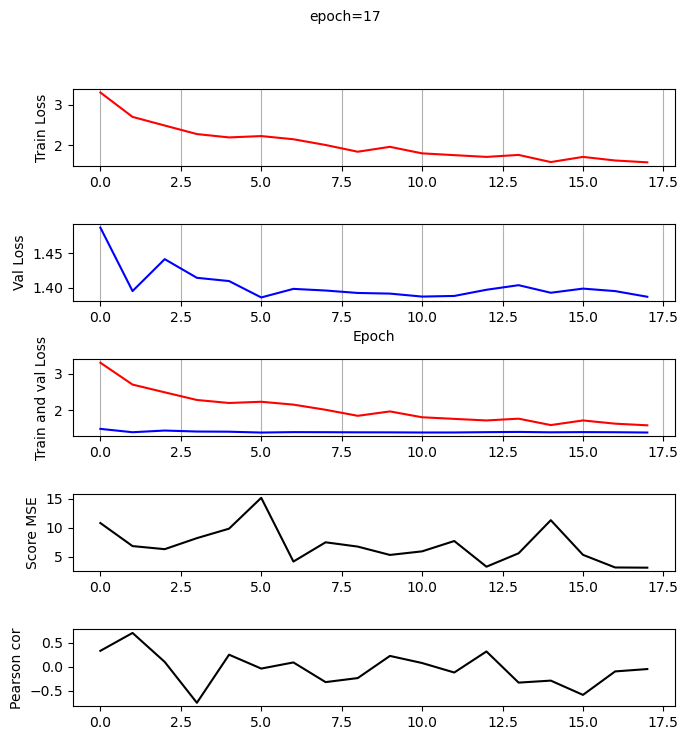

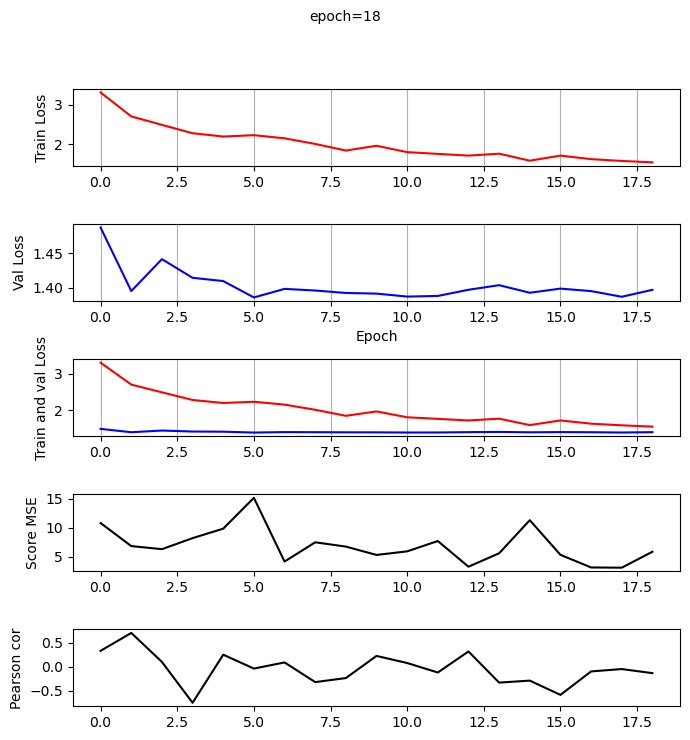

In [13]:
train = Trainer(
            model=legnet, 
            pretraned_model=pretraned_model,
            train_dataloader=dl_train,
            test_dataloader=dl_test,
            criterion=criterion,
            loss_criterion=score_criterion,
            optimizer=optimizer,
            epochs=epochs,
            batch_size=batch_size,
            batch_per_epoch=batch_per_epoch,
            device = device,
            )
try:
    train_losses, test_losses, weights = train.training()
except Exception as e:
    logger.exception("Training failed")

-------------------------------------------------------


In [ ]:
log_contents = log_capture_string.getvalue()
print(log_contents)